In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

To run this notebook, we'll need tensorboard:

In [ ]:
!pip install tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
# from sklearn.base import TransformerMixin

from u8timeseries import TimeSeries
from u8timeseries.utils import TimeSeriesDataset1D
from u8timeseries import RNN, RNNModel
from u8timeseries import Transformer

In [3]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Air Passenger with vanilla RNN and LSTM

In [4]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

In [5]:
def training_split(data: TimeSeries, test_ts: pd.Timestamp, val_ts: pd.Timestamp = None) -> [TimeSeries]:
    """
    in order: test, [val,] train
    """
    split_series = []
    assert data.in_range_index(test_ts), "The splitting time stamp is outside the time range"
    train, test = data.split_after(test_ts)
    split_series.append(test)
    if val_ts is not None:
        assert train.in_range_index(val_ts), "The splitting time stamp is outside the training time range"
        train, val = train.split_after(val_ts)
        split_series.append(val)
    split_series.append(train)
    return split_series

In [6]:
# Number of features/channels used as input.
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12 # 132
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_SIZE = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [7]:
# scaler = MinMaxScaler()
# scaler.fit(series.values().reshape(-1, 1))

In [9]:
val, train = training_split(series, pd.Timestamp('19580101'))

transformer = Transformer()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)

In [10]:
my_model = RNNModel('RNN', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=32, n_epochs=200, optimizer_kwargs={'lr': 1e-2}, 
                    exp_name='Air_RNN', vis_tb=True)

In [11]:
# my_model.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
# my_model.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99)

In [13]:
my_model.fit(train_transformed, val_transformed)  # 107

Training loss: 0.0046, validation loss: 0.0209


Result of training

In [70]:
my_model.plot_result_train()

AttributeError: 'RNNModel' object has no attribute 'plot_result_train'

Test with horizon=1:

In [21]:
my_model.test_series(test_transformed)

AttributeError: 'RNNModel' object has no attribute 'test_series'

Test with horizon=38, and feeding predictions

=> loaded checkpoint (epoch 200)


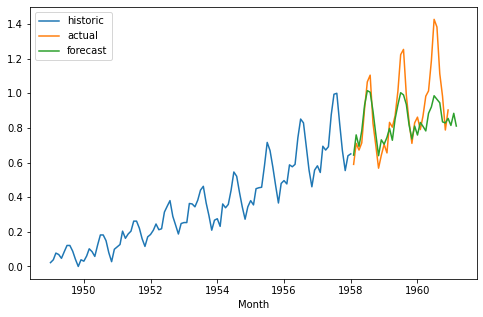

In [15]:
pred_series = my_model.predict(n=38)
plt.figure(figsize=(8,5))
train_transformed.plot(label='historic')
val_transformed.plot(label='actual')
pred_series.plot(label='forecast')
plt.legend();

#### LSTM

In [39]:
my_model_lstm = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                         batch_size=32, n_epochs=1000, exp_name='Air_LSTM', vis_tb=True)

In [40]:
my_model_lstm.set_val_series(test)

In [41]:
my_model_lstm.fit(train)  # 107

Training loss: 0.0042, validation loss: 0.0146


In [47]:
my_model_lstm.load_from_checkpoint(is_best=True)

=> loaded checkpoint (epoch 891)


In [43]:
my_model_lstm.fit(train)  # 107

Result of training

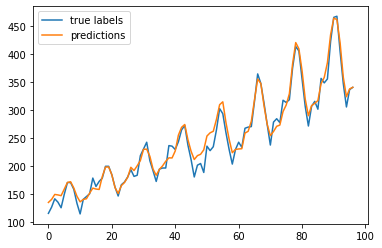

Loss: 175.065414


In [48]:
my_model_lstm.plot_result_train()

Test with horizon=1, and feeding ground truth

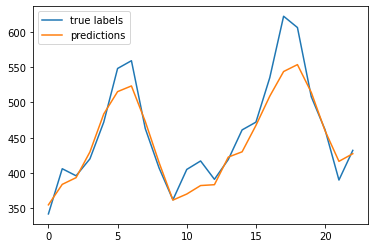

Loss: 748.739197


In [49]:
my_model_lstm.test_series(test)

Test with horizon=38, and feeding predictions

=> loaded checkpoint (epoch 1000)


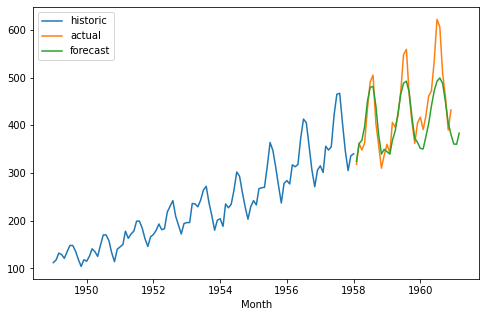

In [50]:
pred_series = my_model_lstm.predict(train, n=38)
plt.figure(figsize=(8,5))
train.plot(label='historic')
test.plot(label='actual')
pred_series.plot(label='forecast')
plt.legend();

In [ ]:
# If recreate the model only from checkpoint, must set the train dataset too
# my_model_lstm.set_train_dataset(train)

=> loaded checkpoint (epoch 891)


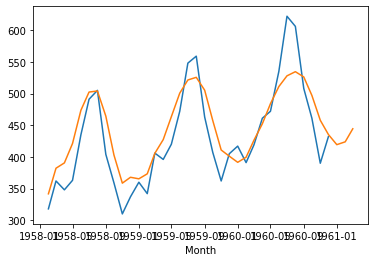

In [51]:
pred_series = my_model_lstm.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

#### GRU

In [ ]:
my_model_gru = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, exp_name='Air_GRU', vis_tb=True)

In [ ]:
my_model_gru.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_gru.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [ ]:
my_model_gru.set_val_series(test)

In [ ]:
my_model_gru.fit(train)  # 107

Result of training

In [ ]:
my_model_gru.plot_result_train()

Test with horizon=1, and feeding ground truth

In [ ]:
my_model_gru.test_series(test)

Test with horizon=38, and feeding predictions

In [ ]:
pred_series = my_model_gru.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

In [ ]:
train.plot()
test.plot()
pred_series.plot()

__Longer output__

In [ ]:
my_model_gru = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE*12, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, exp_name='Air_GRU_out12', vis_tb=True)

In [ ]:
my_model_gru.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_gru.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [ ]:
my_model_gru.set_val_series(test)

In [ ]:
my_model_gru.fit(train)  # 107

Result of training

In [ ]:
my_model_gru.plot_result_train()

Test with horizon=1, and feeding ground truth

In [ ]:
my_model_gru.test_series(test)

Test with horizon=28, and feeding predictions

In [ ]:
pred_series = my_model_gru.predict(train, n=38, is_best=True)
test.plot()
pred_series.plot()

Full output at time T

T = end of train time series

In [ ]:
pred_series = my_model_gru.true_predict(train, is_best=False)
train.plot()
test.plot()
pred_series.shift(0).plot()

T = -40

In [ ]:
pred_series = my_model_gru.true_predict(train[:-40], is_best=False)
train.plot()
pred_series.plot()

T = end of test time series

In [ ]:
pred_series = my_model_gru.true_predict(test, is_best=True)
train.plot()
test.plot()
pred_series.shift(0).plot()

## monthly sunspot

In [ ]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series2 = TimeSeries.from_dataframe(df2, 'Month', 'Sunspots')

In [ ]:
series2[:].plot()

In [ ]:
from u8timeseries.models.statistics import check_seasonality, plot_acf

In [ ]:
check_seasonality(series2, max_lag=240)

In [ ]:
plot_acf(series2, 132, max_lag=240) # 11 years seasonality

In [ ]:
test, train = training_split(series2, pd.Timestamp('19401001'))

In [ ]:
INPUT_SIZE = 1
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
OUTPUT_SIZE = 50
NUM_LAYERS = 3

In [ ]:
my_model_sun = RNNModel('GRU', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=600, exp_name='sun_GRU', vis_tb=True)

In [ ]:
my_model_sun.set_optimizer(torch.optim.Adam, learning_rate=1e-4)
my_model_sun.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.995)

In [ ]:
my_model_sun.set_val_series(test)

In [ ]:
my_model_sun.fit(train)  # 107

In [ ]:
my_model_sun.plot_result_train()

In [ ]:
my_model_sun.test_series(test)

In [ ]:
pred_series = my_model_sun.predict(train, 550, is_best=False)
test.plot()
pred_series.plot()

In [ ]:
pred_series = my_model_sun.true_predict(train, is_best=True)
test[:50].plot()
pred_series.plot()